## Data Description
This dataset contains 21,754 news articles collected from AllSides balanced news headline roundups in November 2022. The dataset was scraped from the AllSides platform on November 15, 2022, and aims to offer multiple political perspectives on important U.S. news stories. Each article is annotated with a bias label—left, right, or center—by four expert annotators, based on the political partisanship expressed in the article. The dataset includes:
* Title: Headline or title of the article.
* Tags: Topics covered in the article (e.g., "Republican party," "coronavirus").
* Heading: Main section or category of the article.
* Source: Publishing news outlet.
* Text: Full content of the article.
* Bias Rating: Expert-assigned political bias (left, right, center).

This dataset can be used to study media bias, detect political partisanship in news articles, or understand how different media outlets present news from various perspectives.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [2]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngoum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ngoum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
df = pd.read_csv("data/allsides_balanced_news_headlines-texts.csv")
df = df.drop(columns=["Unnamed: 0"])
df.shape

(21754, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21754 entries, 0 to 21753
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        21754 non-null  object
 1   tags         21754 non-null  object
 2   heading      21754 non-null  object
 3   source       21746 non-null  object
 4   text         21747 non-null  object
 5   bias_rating  21754 non-null  object
dtypes: object(6)
memory usage: 1019.8+ KB


## Handle Missing Values
Certain columns such as `text` and `source` are missing values. An article `text` is highly relevant when predicting the bias of a given article. We may, therefore, drop the rows with missing `text`. When it comes to `source`, a decision must be made if the source of a news article should be included our models. Certain sources such as CNN and FoxNews are known to be biased and may heavily influence the models decision process. For the time being, we could remove `source` for analysis.

In [5]:
df.isnull().sum()

title          0
tags           0
heading        0
source         8
text           7
bias_rating    0
dtype: int64

In [6]:
df = df.dropna()

## Data Exploration

The target variable (`bias_rating`) is in text format, we convert it to an ordinal form for analysis.

In [7]:
bias_mapping = {'left': 1, 'center': 0, 'right': 1}
df['bias_numeric'] = df['bias_rating'].map(bias_mapping)

In [9]:
df['bias_numeric'].value_counts()

bias_numeric
1    17495
0     4244
Name: count, dtype: int64

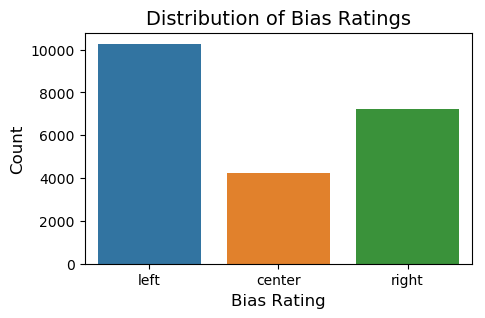

In [8]:
plt.figure(figsize=(5, 3))
sns.countplot(x='bias_rating', data=df, order=['left', 'center', 'right'])
plt.title('Distribution of Bias Ratings', fontsize=14)
plt.xlabel('Bias Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

#### Event ID
Considering that `title` refers to a neutral title assigned to each article by AllSides, we could use them to uniquely identify stories/events.

In [9]:
# Create a dictionary to map each unique title to a unique event_id
unique_titles = df['title'].unique()
title_to_event_id = {title: idx for idx, title in enumerate(unique_titles)}
# Map the event_id to the DataFrame based on the "title" column
df['event_id'] = df['title'].map(title_to_event_id)

A number of features could be extracted from all of the columns we have in our dataset.

#### News Tags/Topics

In [10]:
top_tags = df['tags'].apply(lambda x: (re.sub("\'|\[|\]", "", x)).split(', ')).explode().value_counts()

In [11]:
len(top_tags)

2567

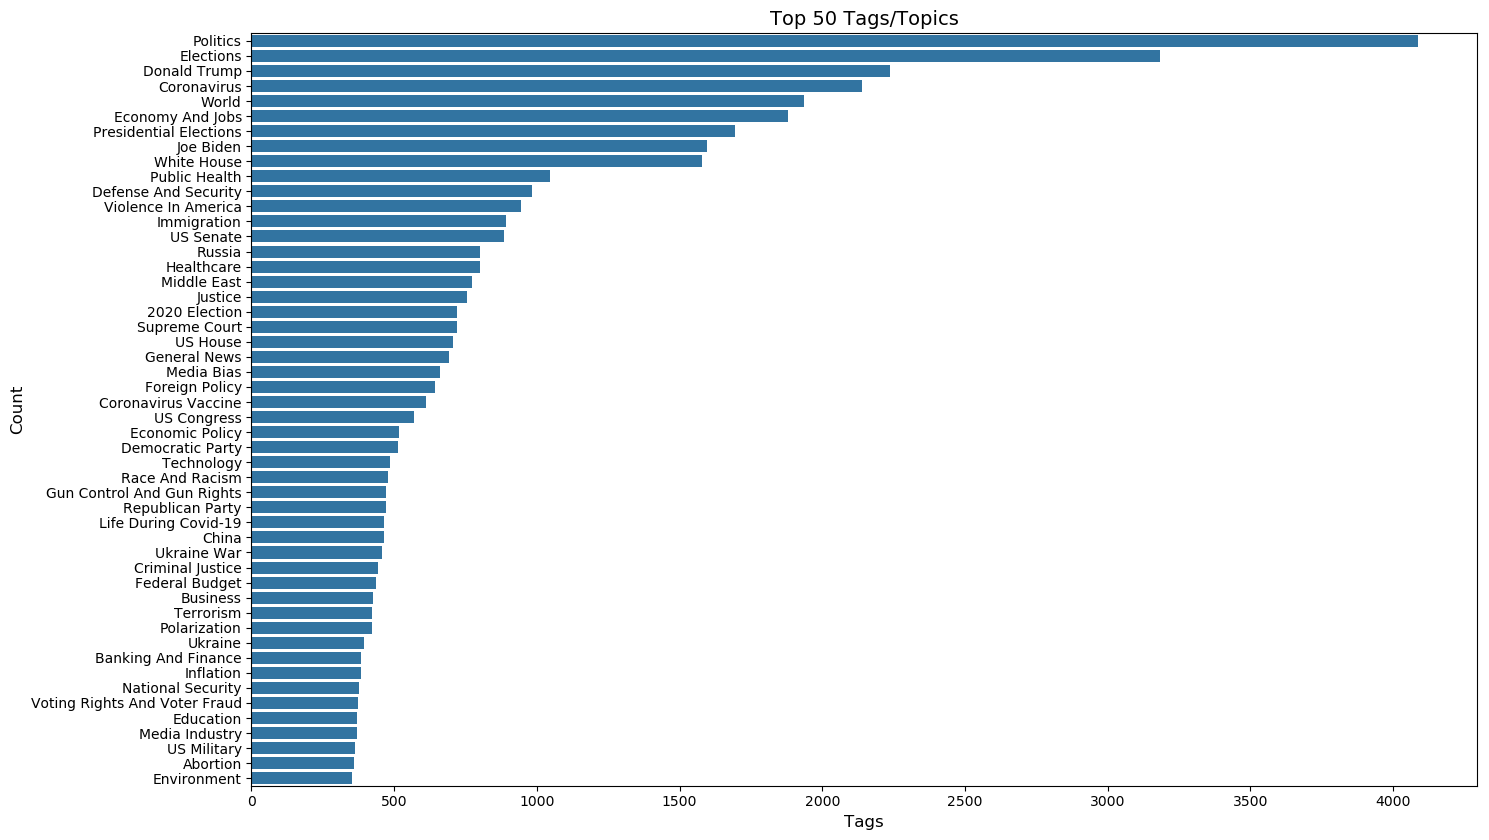

In [12]:
plt.figure(figsize=(15, 8.5))
k = 50
sns.barplot(y=top_tags.nlargest(k).index, x=top_tags.nlargest(k).values, color="tab:blue")
plt.title(f'Top {k} Tags/Topics', fontsize=14)
plt.xlabel('Tags', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

#### Source Bias

In [13]:
df['source'] = df['source'].apply(lambda source: re.sub("\([a-zA-Z ]+\)", "", source).strip())

In [14]:
df['source'].unique().shape[0]

458

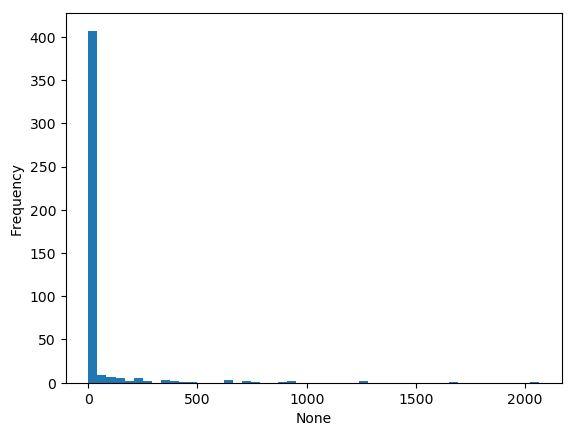

In [15]:
source_counts = df['source'].value_counts()
source_counts.plot(kind='hist', bins=50)
plt.show()

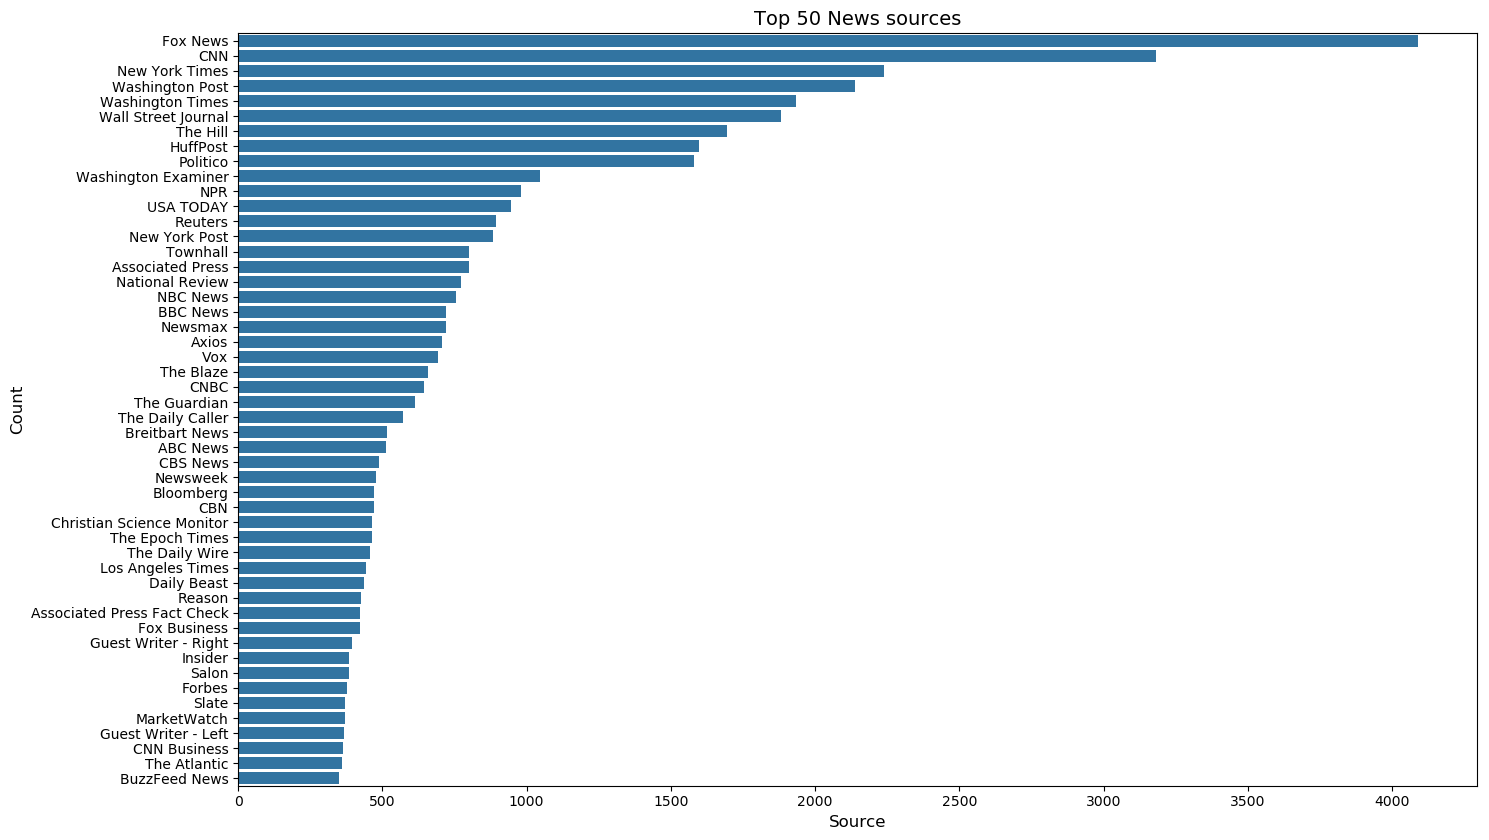

In [16]:
plt.figure(figsize=(15, 8.5))
k = 50
sns.barplot(y=source_counts.nlargest(k).index, x=top_tags.nlargest(k).values, color="tab:blue")
plt.title(f'Top {k} News sources', fontsize=14)
plt.xlabel('Source', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()

We have 458 unique News sources. Some have throusands of articles in the dataset while others have as little as one. For more balance, we would set the sources having a number of articles below a given threshold to "Other".

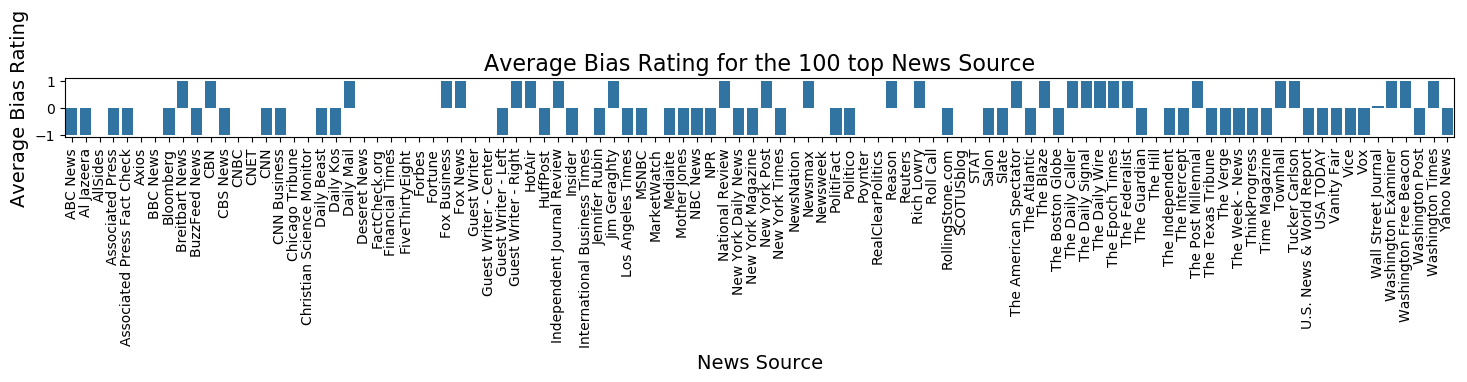

In [17]:
k = 100
average_bias_per_source = df[df["source"].isin(source_counts.head(k).index)].groupby('source')['bias_numeric'].mean().reset_index()
# Plot the average bias
plt.figure(figsize=(15, 3.5))
bar_plot = sns.barplot(data=average_bias_per_source, x='source', y='bias_numeric', color="tab:blue")
# Set the title and labels
plt.title(f'Average Bias Rating for the {k} top News Source', fontsize=16)
plt.ylabel('Average Bias Rating', fontsize=14)
plt.xlabel('News Source', fontsize=14)
plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

There seem to be a very strong correlation between the News source and bias rating. All articles of each news sources are generally labelled with the same rating. Because of this, a simple model could just focus on the news source and make a correct predicition. However, the purpose of this project is to identify the bias in a given news article regarless of the source. `source` may therefore be dropped from the features set.

#### Sentiment Analysis

In [18]:
df['is_question_headline'] = df['title'].apply(lambda x: int(x.endswith('?')))

In [19]:
df['is_question_headline'].value_counts()

is_question_headline
0    20890
1      849
Name: count, dtype: int64

In [20]:
df['text_sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['heading_sentiment'] = df['heading'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [21]:
df['text_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['heading_subjectivity'] = df['heading'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [22]:
df['heading_text_sentiment_diff'] = df['heading_sentiment'] - df['text_sentiment']

Plot the average sentiment per bias for each topic

In [23]:
df.loc[df["tags"] == "[]", "tags"] = "N/A"

In [24]:
df_exploded = df.copy()
df_exploded['tags'] = df_exploded['tags'].apply(lambda tag: re.sub(r"[\'\[\]]", "", tag).split(', '))
# Explode the 'tags' column to get one tag per row
df_exploded = df_exploded.explode('tags')

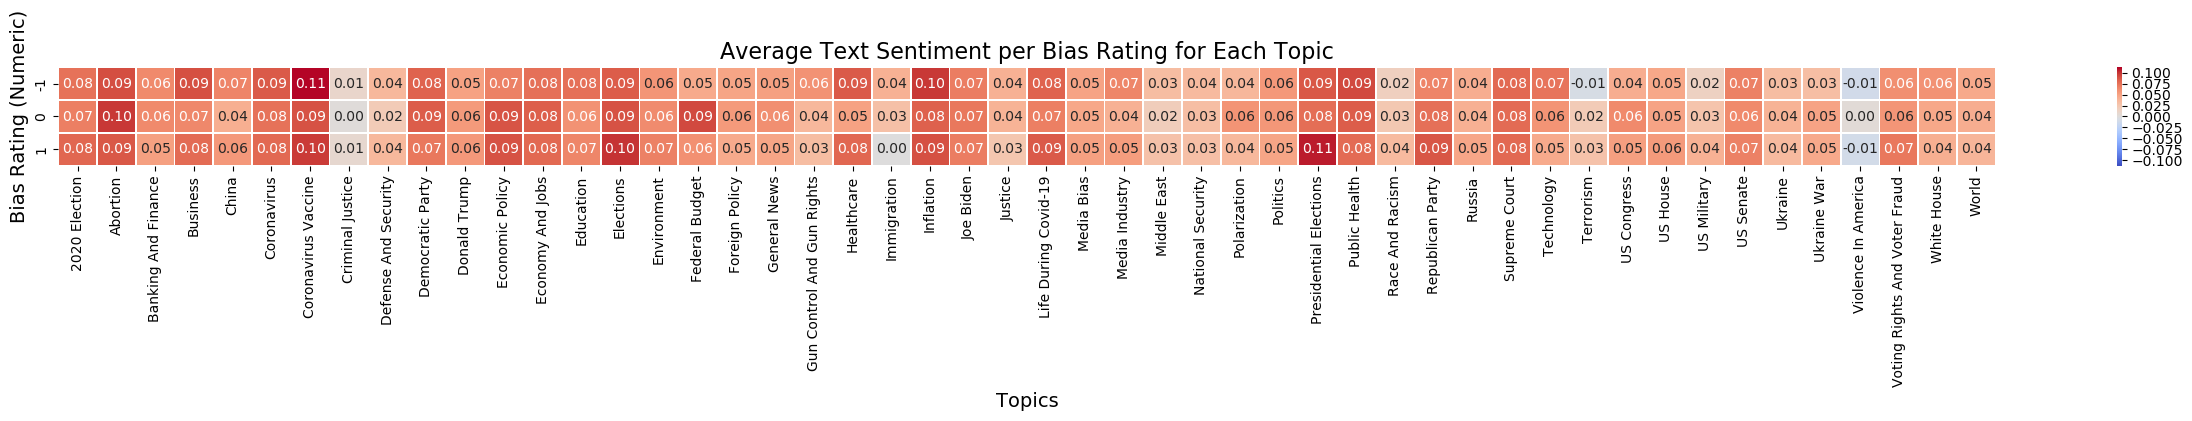

In [25]:
avg_text_sentiment_per_tag_bias = (
    df_exploded[df_exploded["tags"].isin(top_tags.nlargest(50).index)]
    .groupby(['tags', 'bias_numeric'])['text_sentiment']
    .mean()
    .reset_index()
)
vlim = max(np.abs(avg_text_sentiment_per_tag_bias['text_sentiment'].min()), np.abs(avg_text_sentiment_per_tag_bias['text_sentiment'].max()))
# Pivot the DataFrame for heatmap
sentiment_pivot = avg_text_sentiment_per_tag_bias.pivot(index='bias_numeric', columns='tags', values='text_sentiment')
# Set the aesthetics for the plot
plt.figure(figsize=(25, 4))
heatmap = sns.heatmap(
    sentiment_pivot,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5,
    vmin=-vlim, vmax=vlim
)
# Set the title and labels
plt.title('Average Text Sentiment per Bias Rating for Each Topic', fontsize=16)
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Bias Rating (Numeric)', fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

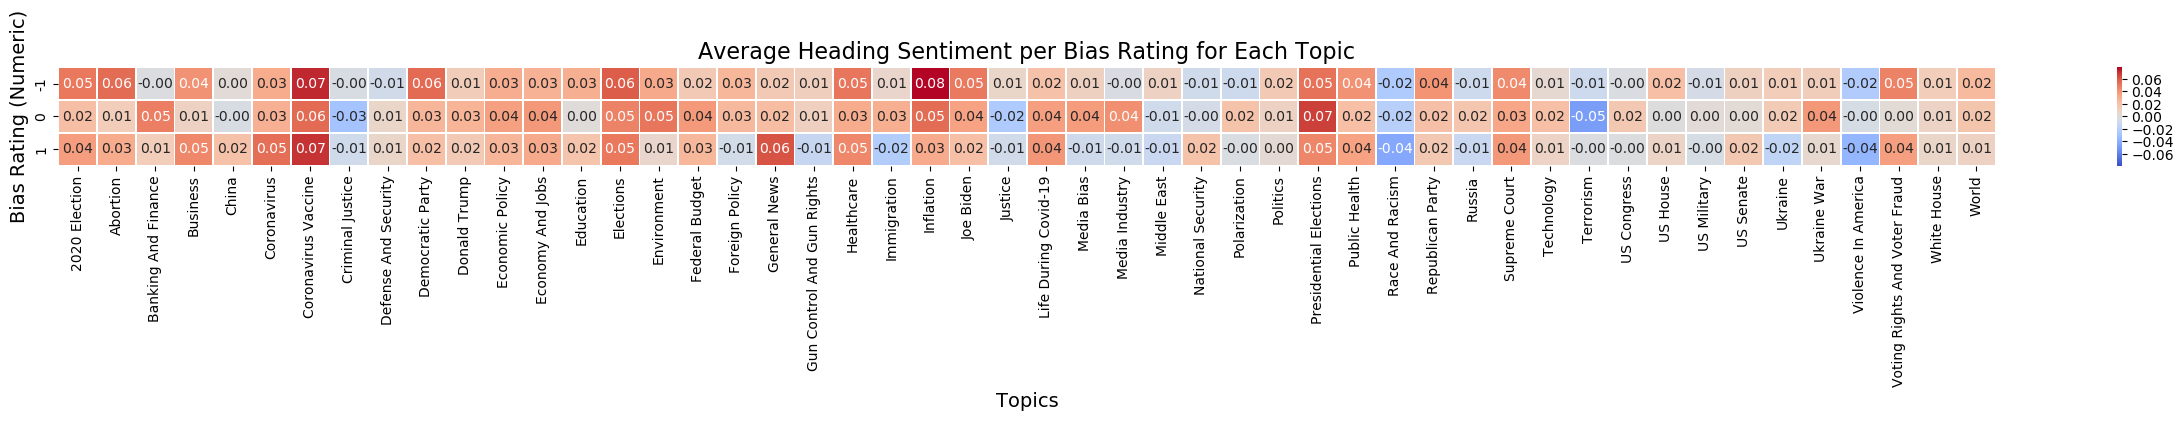

In [26]:
avg_heading_sentiment_per_tag_bias = (
    df_exploded[df_exploded["tags"].isin(top_tags.nlargest(50).index)]
    .groupby(['tags', 'bias_numeric'])['heading_sentiment']
    .mean()
    .reset_index()
)
vlim = max(np.abs(avg_heading_sentiment_per_tag_bias['heading_sentiment'].min()), np.abs(avg_heading_sentiment_per_tag_bias['heading_sentiment'].max()))
# Pivot the DataFrame for heatmap
sentiment_pivot = avg_heading_sentiment_per_tag_bias.pivot(index='bias_numeric', columns='tags', values='heading_sentiment')
# Set the aesthetics for the plot
plt.figure(figsize=(25, 4))
heatmap = sns.heatmap(
    sentiment_pivot,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=.5,
    vmin=-vlim, vmax=vlim
)
# Set the title and labels
plt.title('Average Heading Sentiment per Bias Rating for Each Topic', fontsize=16)
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Bias Rating (Numeric)', fontsize=14)
# Show the plot
plt.tight_layout()
plt.show()

#### Text lengths

In [27]:
df['text_length'] = df['text'].apply(len)

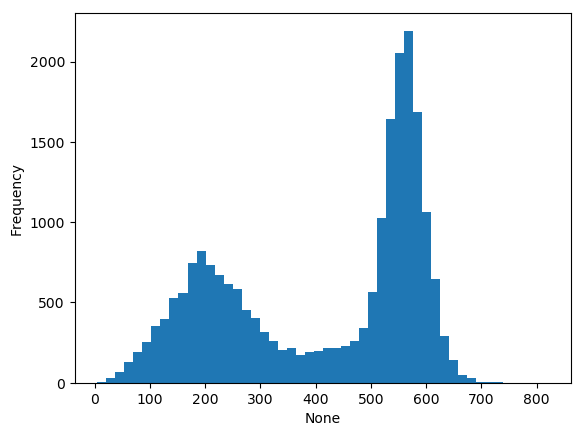

In [31]:
df['text_length'].plot(kind="hist", bins=50)

In [34]:
df['num_tokens'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

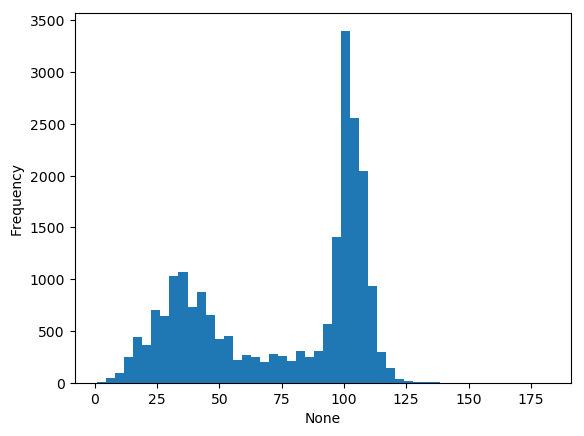

In [35]:
df['num_tokens'].plot(kind="hist", bins=50)